In [69]:
from __future__ import print_function, division
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

import copy

plt.ion()   # interactive mode
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [70]:
%ls drive/MyDrive/MyThesis/oxford/Master

Testing/  Train/  Validation/


# **Preparing Dataset for model**

In [71]:
data_transforms = {
    'Train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
    'Validation': transforms.Compose([
                              transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ]),
    'Testing': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# data_dir  = 'drive/MyDrive/MyThesis/hymenoptera_data/*'
data_dir = 'drive/MyDrive/MyThesis/oxford/Master'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Validation','Testing']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['Train', 'Validation','Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Validation','Testing']}

class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [72]:
print(class_names)
print(dataloaders['Train'])

['Abyssinian', 'Russian_Blue', 'Sphynx', 'american_bulldog', 'american_pitbull', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


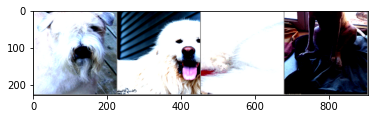

wheaten_terrier great_pyrenees great_pyrenees american_bulldog


In [73]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(dataloaders['Train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [74]:
metrics_eval_resnet = [] 
metrics_eval_effecientNet = [] 
def train_model(model, model_name,criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
   
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # inputs = inputs
                # labels = labels

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if model_name == "efficientNet-B7":
                metrics_eval_effecientNet.append(epoch_acc)
                # print("berhasil tersimpan epoch efficientNet")
            else:
                metrics_eval_resnet.append(epoch_acc)
                # print("berhasil tersimpan epoch resnet")

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [75]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [76]:
#Finetuning the convnet

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 37.

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 37)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [77]:
model_ft = train_model(model_ft,"resnet-50", criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 1/20
----------
Train Loss: 1.8192 Acc: 0.4843
Validation Loss: 0.5652 Acc: 0.8378

Epoch 2/20
----------
Train Loss: 1.3722 Acc: 0.6007
Validation Loss: 0.8788 Acc: 0.7983

Epoch 3/20
----------
Train Loss: 1.3099 Acc: 0.6320
Validation Loss: 0.5852 Acc: 0.8449

Epoch 4/20
----------
Train Loss: 1.1714 Acc: 0.6631
Validation Loss: 0.5800 Acc: 0.8491

Epoch 5/20
----------
Train Loss: 1.0988 Acc: 0.6814
Validation Loss: 0.6149 Acc: 0.8505

Epoch 6/20
----------
Train Loss: 1.0423 Acc: 0.6940
Validation Loss: 0.6488 Acc: 0.8449

Epoch 7/20
----------
Train Loss: 0.9980 Acc: 0.7077
Validation Loss: 0.8019 Acc: 0.8307

Epoch 8/20
----------
Train Loss: 0.7402 Acc: 0.7845
Validation Loss: 0.3238 Acc: 0.9126

Epoch 9/20
----------
Train Loss: 0.6333 Acc: 0.8182
Validation Loss: 0.2902 Acc: 0.9224

Epoch 10/20
----------
Train Loss: 0.5759 Acc: 0.8295
Validation Loss: 0.2805 Acc: 0.9252

Epoch 11/20
----------
Train Loss: 0.5706 Acc: 0.8333
Validation Loss: 0.2547 Acc: 0.9323

Epoch 12

In [78]:
# Each epoch has a training and validation phase
for phase in ['Testing']:
    model_ft.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        # optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'Train'):
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

Testing Loss: 0.5606 Acc: 0.8480


In [82]:
#Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


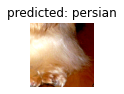

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


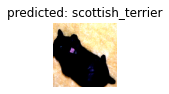

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


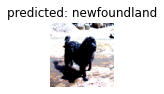

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


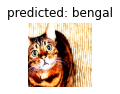

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


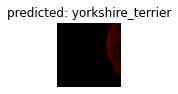

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


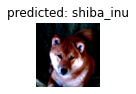

In [83]:
visualize_model(model_ft)

In [84]:
torch.save(model_ft,'drive/MyDrive/MyThesis/resnet50oxford.model')